# Imports

In [79]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import seaborn as sns
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AdamWeightDecay
from tensorflow.keras.optimizers import Adam

In [3]:
import mlflow
import mlflow.sklearn

# init

In [80]:
data_title = pd.read_csv("df_bow_title.csv")
data_tags = pd.read_csv("df_bow_tags.csv")

In [81]:
data_title=data_title.drop(['Unnamed: 0'], axis=1)
data_tags=data_tags.drop(['Unnamed: 0'], axis=1)

# Initialisation MLFlow

! PENSER A LANCER mlflow ui avant d'aller plus loin, sinon l'exécution ne se fera pas

In [82]:
mlflow.set_tracking_uri("http://localhost:5000")  # Définir l'URI de suivi de MLflow (facultatif)
mlflow.set_experiment("ML_Not_supervised_28_06")

2024/06/28 16:03:53 INFO mlflow.tracking.fluent: Experiment with name 'ML_Not_supervised_28_06' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/319907953237469055', creation_time=1719583433850, experiment_id='319907953237469055', last_update_time=1719583433850, lifecycle_stage='active', name='ML_Not_supervised_28_06', tags={}>

# Word2Vec 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def convert_to_tags_list(df):
    return df.apply(lambda x: [df.columns[i] for i in range(len(x)) if x[i] != 0], axis=1).tolist()

tags_list = convert_to_tags_list(data_tags)
# Binariser les étiquettes
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(tags_list)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_title, y, test_size=0.2, random_state=42)
def train_and_compare_models(data_title, data_tags,X_train, X_test, y_train, y_test):

    with mlflow.start_run(run_name=f"Modèle Word2Vec"):

        # Utiliser OneVsRestClassifier pour multi-label classification
        model = OneVsRestClassifier(MultinomialNB(alpha=1.0))
        model.fit(X_train, y_train)

        # Prédire les tags pour l'ensemble de test
        y_pred = model.predict(X_test)

        # Calculer les métriques
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")
        print(classification_report(y_test, y_pred, target_names=mlb.classes_))

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_param("alpha", 1.0)
        mlflow.sklearn.log_model(model, f"model_Word2Vec")
        return y_pred,accuracy

# Appel de la fonction pour entraîner et comparer les modèles
y_pred ,accuracy=train_and_compare_models(data_title, data_tags,X_train, X_test, y_train, y_test)

C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_29356\3162631331.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.apply(lambda x: [df.columns[i] for i in range(len(x)) if x[i] != 0], axis=1).tolist()


Accuracy: 0.15
                precision    recall  f1-score   support

            20       0.00      0.00      0.00        84
     algorithm       0.00      0.00      0.00       107
        amazon       0.00      0.00      0.00       299
       android       0.97      0.39      0.56       705
       angular       0.93      0.37      0.53       149
        apache       0.00      0.00      0.00       204
           api       1.00      0.02      0.04       280
        arrays       1.00      0.01      0.01       180
           asp       0.00      0.00      0.00       192
authentication       0.00      0.00      0.00       124
           aws       0.00      0.00      0.00       171
         azure       1.00      0.56      0.72       264
          boot       0.69      0.13      0.22       246
        chrome       0.00      0.00      0.00        77
         cloud       0.00      0.00      0.00       236
          code       0.00      0.00      0.00       172
       compose       0.97      0

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

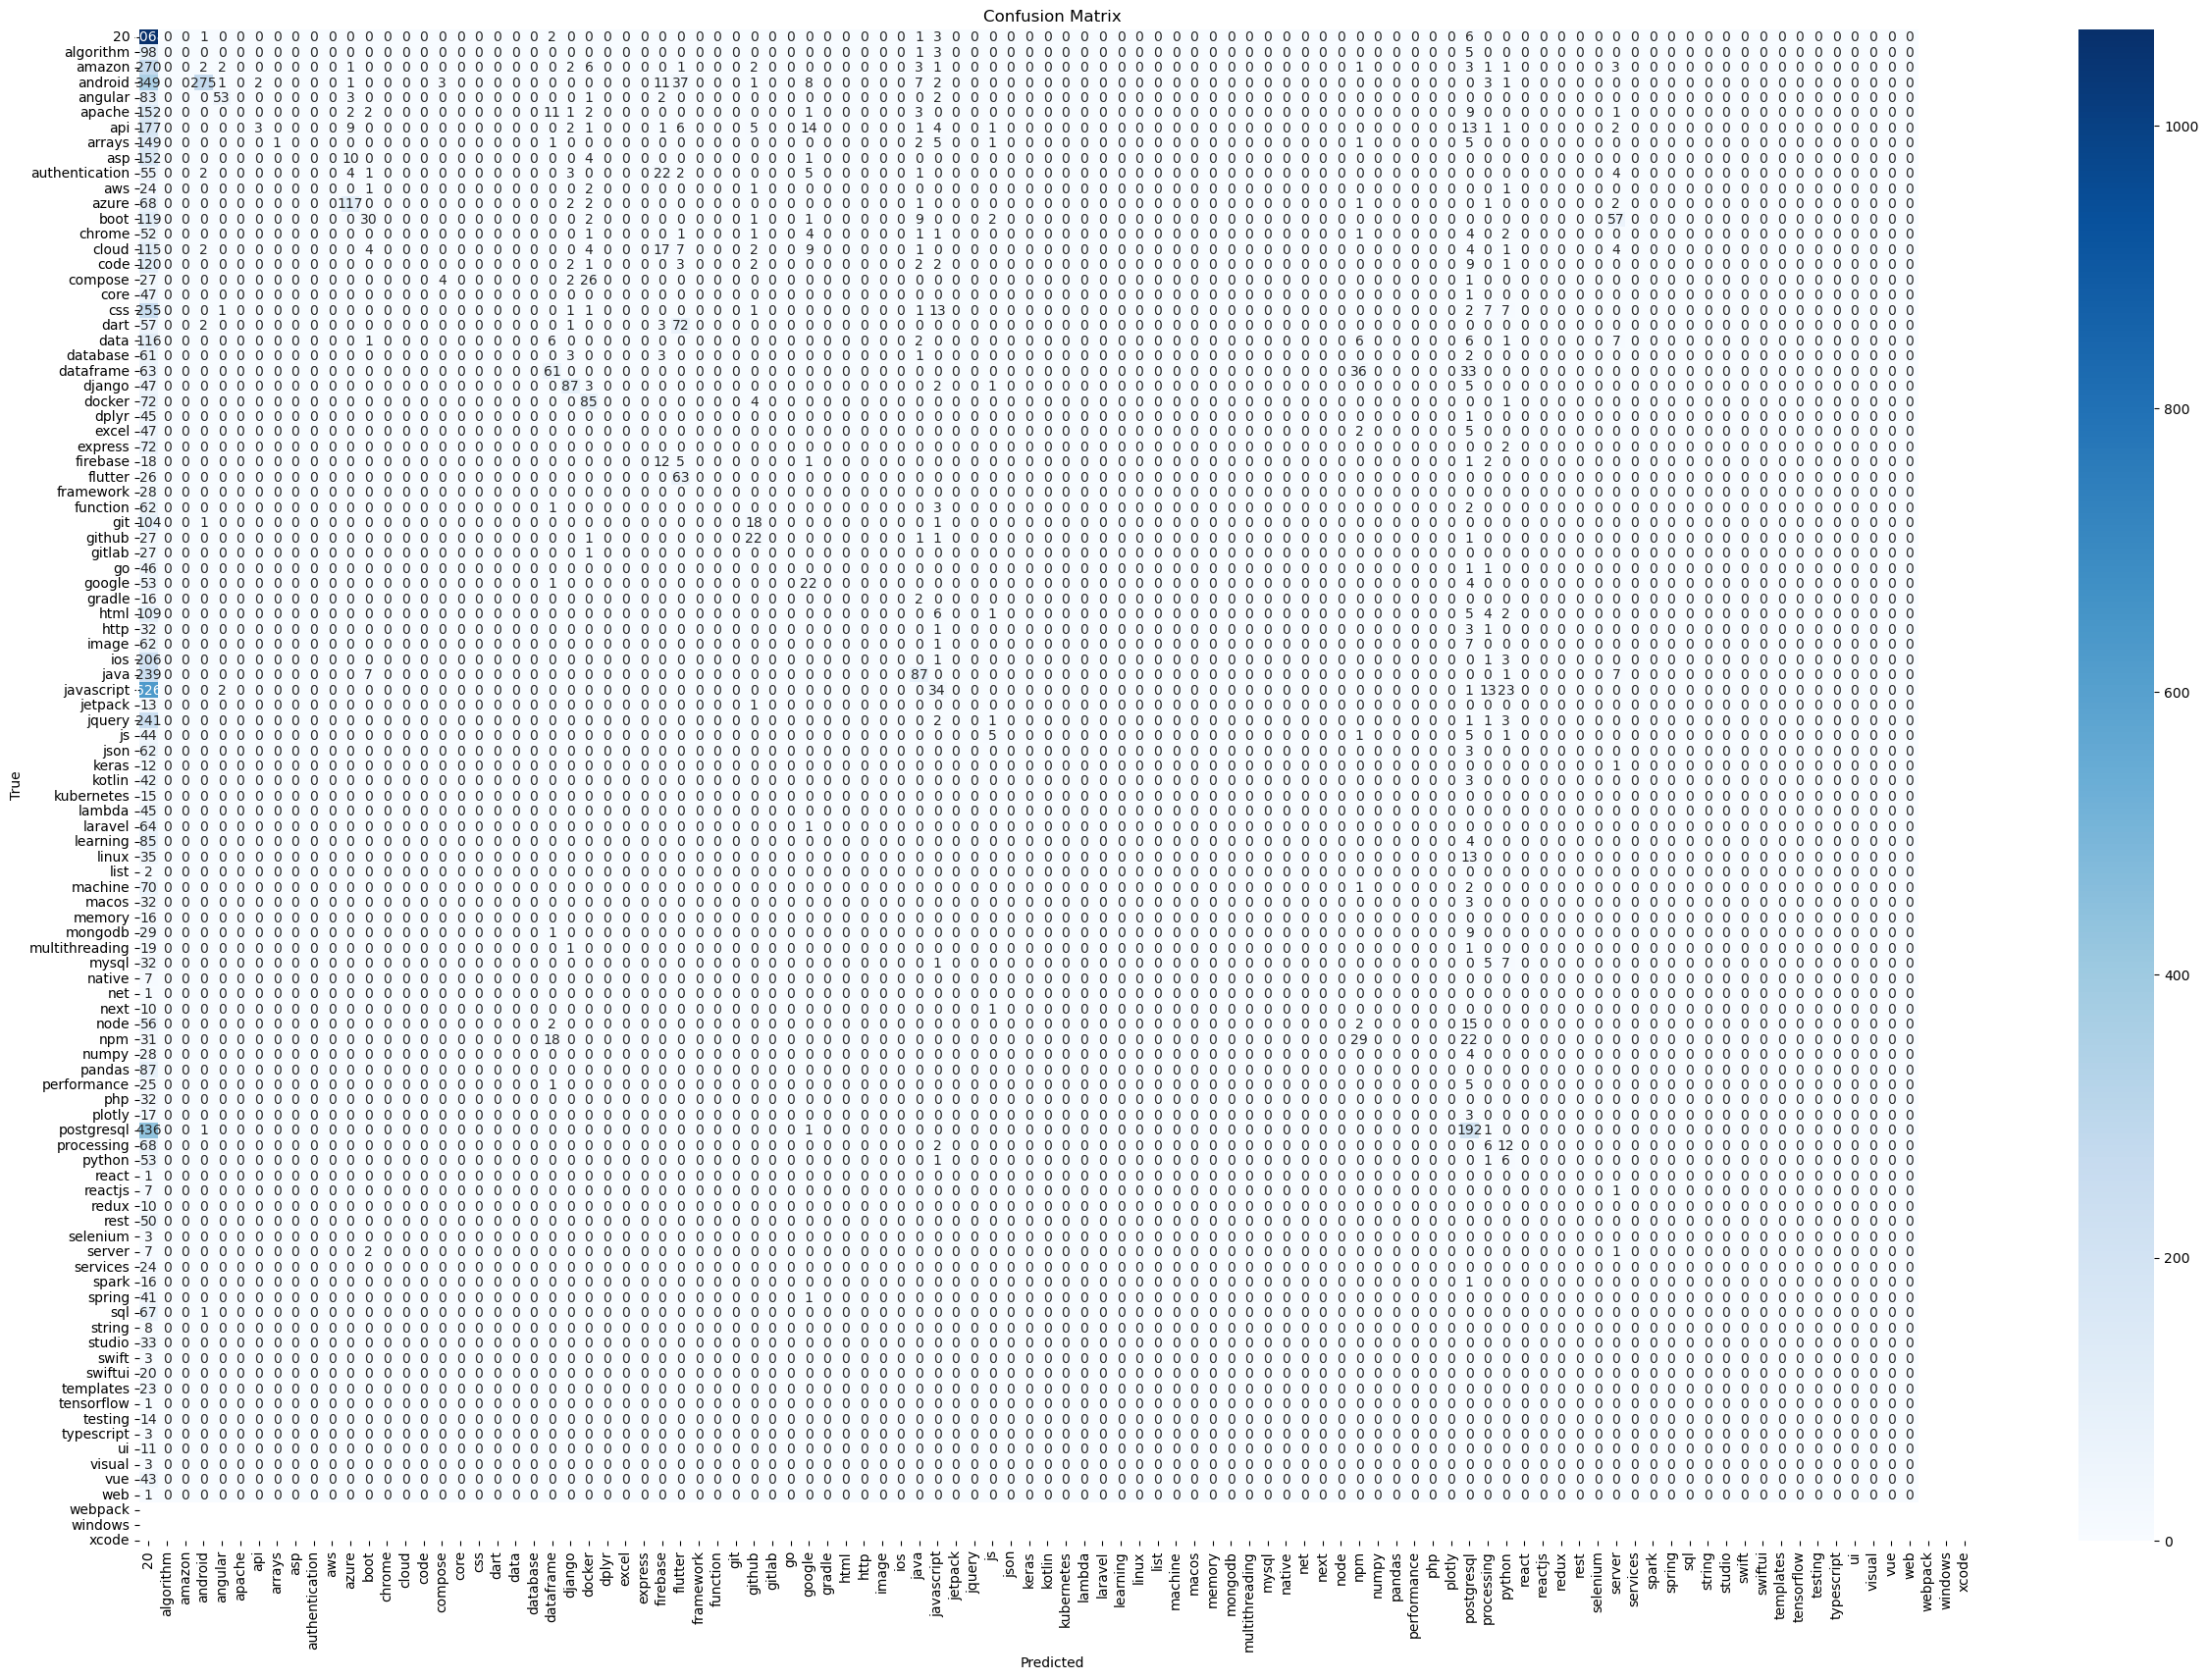

In [7]:
# Tracer la matrice de confusion
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(30, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Neural Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(tags_list)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_title, y, test_size=0.2, random_state=42)

# Création du modèle de réseau de neurones
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Entraînement du modèle
with mlflow.start_run(run_name=f"Modèle Neural Network"):
    mlflow.tensorflow.autolog()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

2024/06/24 11:01:41 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2024/06/24 11:01:41 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/10
1250/1250 [==============================] - 10s 6ms/step - loss: 0.1120 - accuracy: 0.1071 - val_loss: 0.0852 - val_accuracy: 0.1655
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0817 - accuracy: 0.1881 - val_loss: 0.0811 - val_accuracy: 0.1887
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0794 - accuracy: 0.1919 - val_loss: 0.0802 - val_accuracy: 0.1955
Epoch 4/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0785 - accuracy: 0.1947 - val_loss: 0.0798 - val_accuracy: 0.1900
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0780 - accuracy: 0.1966 - val_loss: 0.0795 - val_accuracy: 0.1918
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0776 - accuracy: 0.1958 - val_loss: 0.0794 - val_accuracy: 0.1927
Epoch 7/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0773 - accuracy: 0.1997 - val_loss: 0.0792 - val_accuracy

2024/06/24 11:02:54 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/06/24 11:02:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmp16tirrwz\model\data\model\assets


In [9]:
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculer les métriques
accuracy_adam = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_adam:.2f}")
print("Classification Report:")


313/313 [==============================] - 1s 967us/step
Accuracy: 0.16
Classification Report:


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.00      0.00      0.00       107
           2       0.00      0.00      0.00       299
           3       0.95      0.46      0.61       705
           4       0.93      0.52      0.66       149
           5       0.00      0.00      0.00       204
           6       0.58      0.20      0.30       280
           7       0.61      0.33      0.43       180
           8       0.00      0.00      0.00       192
           9       1.00      0.01      0.02       124
          10       0.00      0.00      0.00       171
          11       1.00      0.63      0.77       264
          12       0.72      0.42      0.53       246
          13       0.00      0.00      0.00        77
          14       0.34      0.10      0.16       236
          15       0.75      0.02      0.03       172
          16       0.95      0.48      0.64       183
          17       0.00    

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

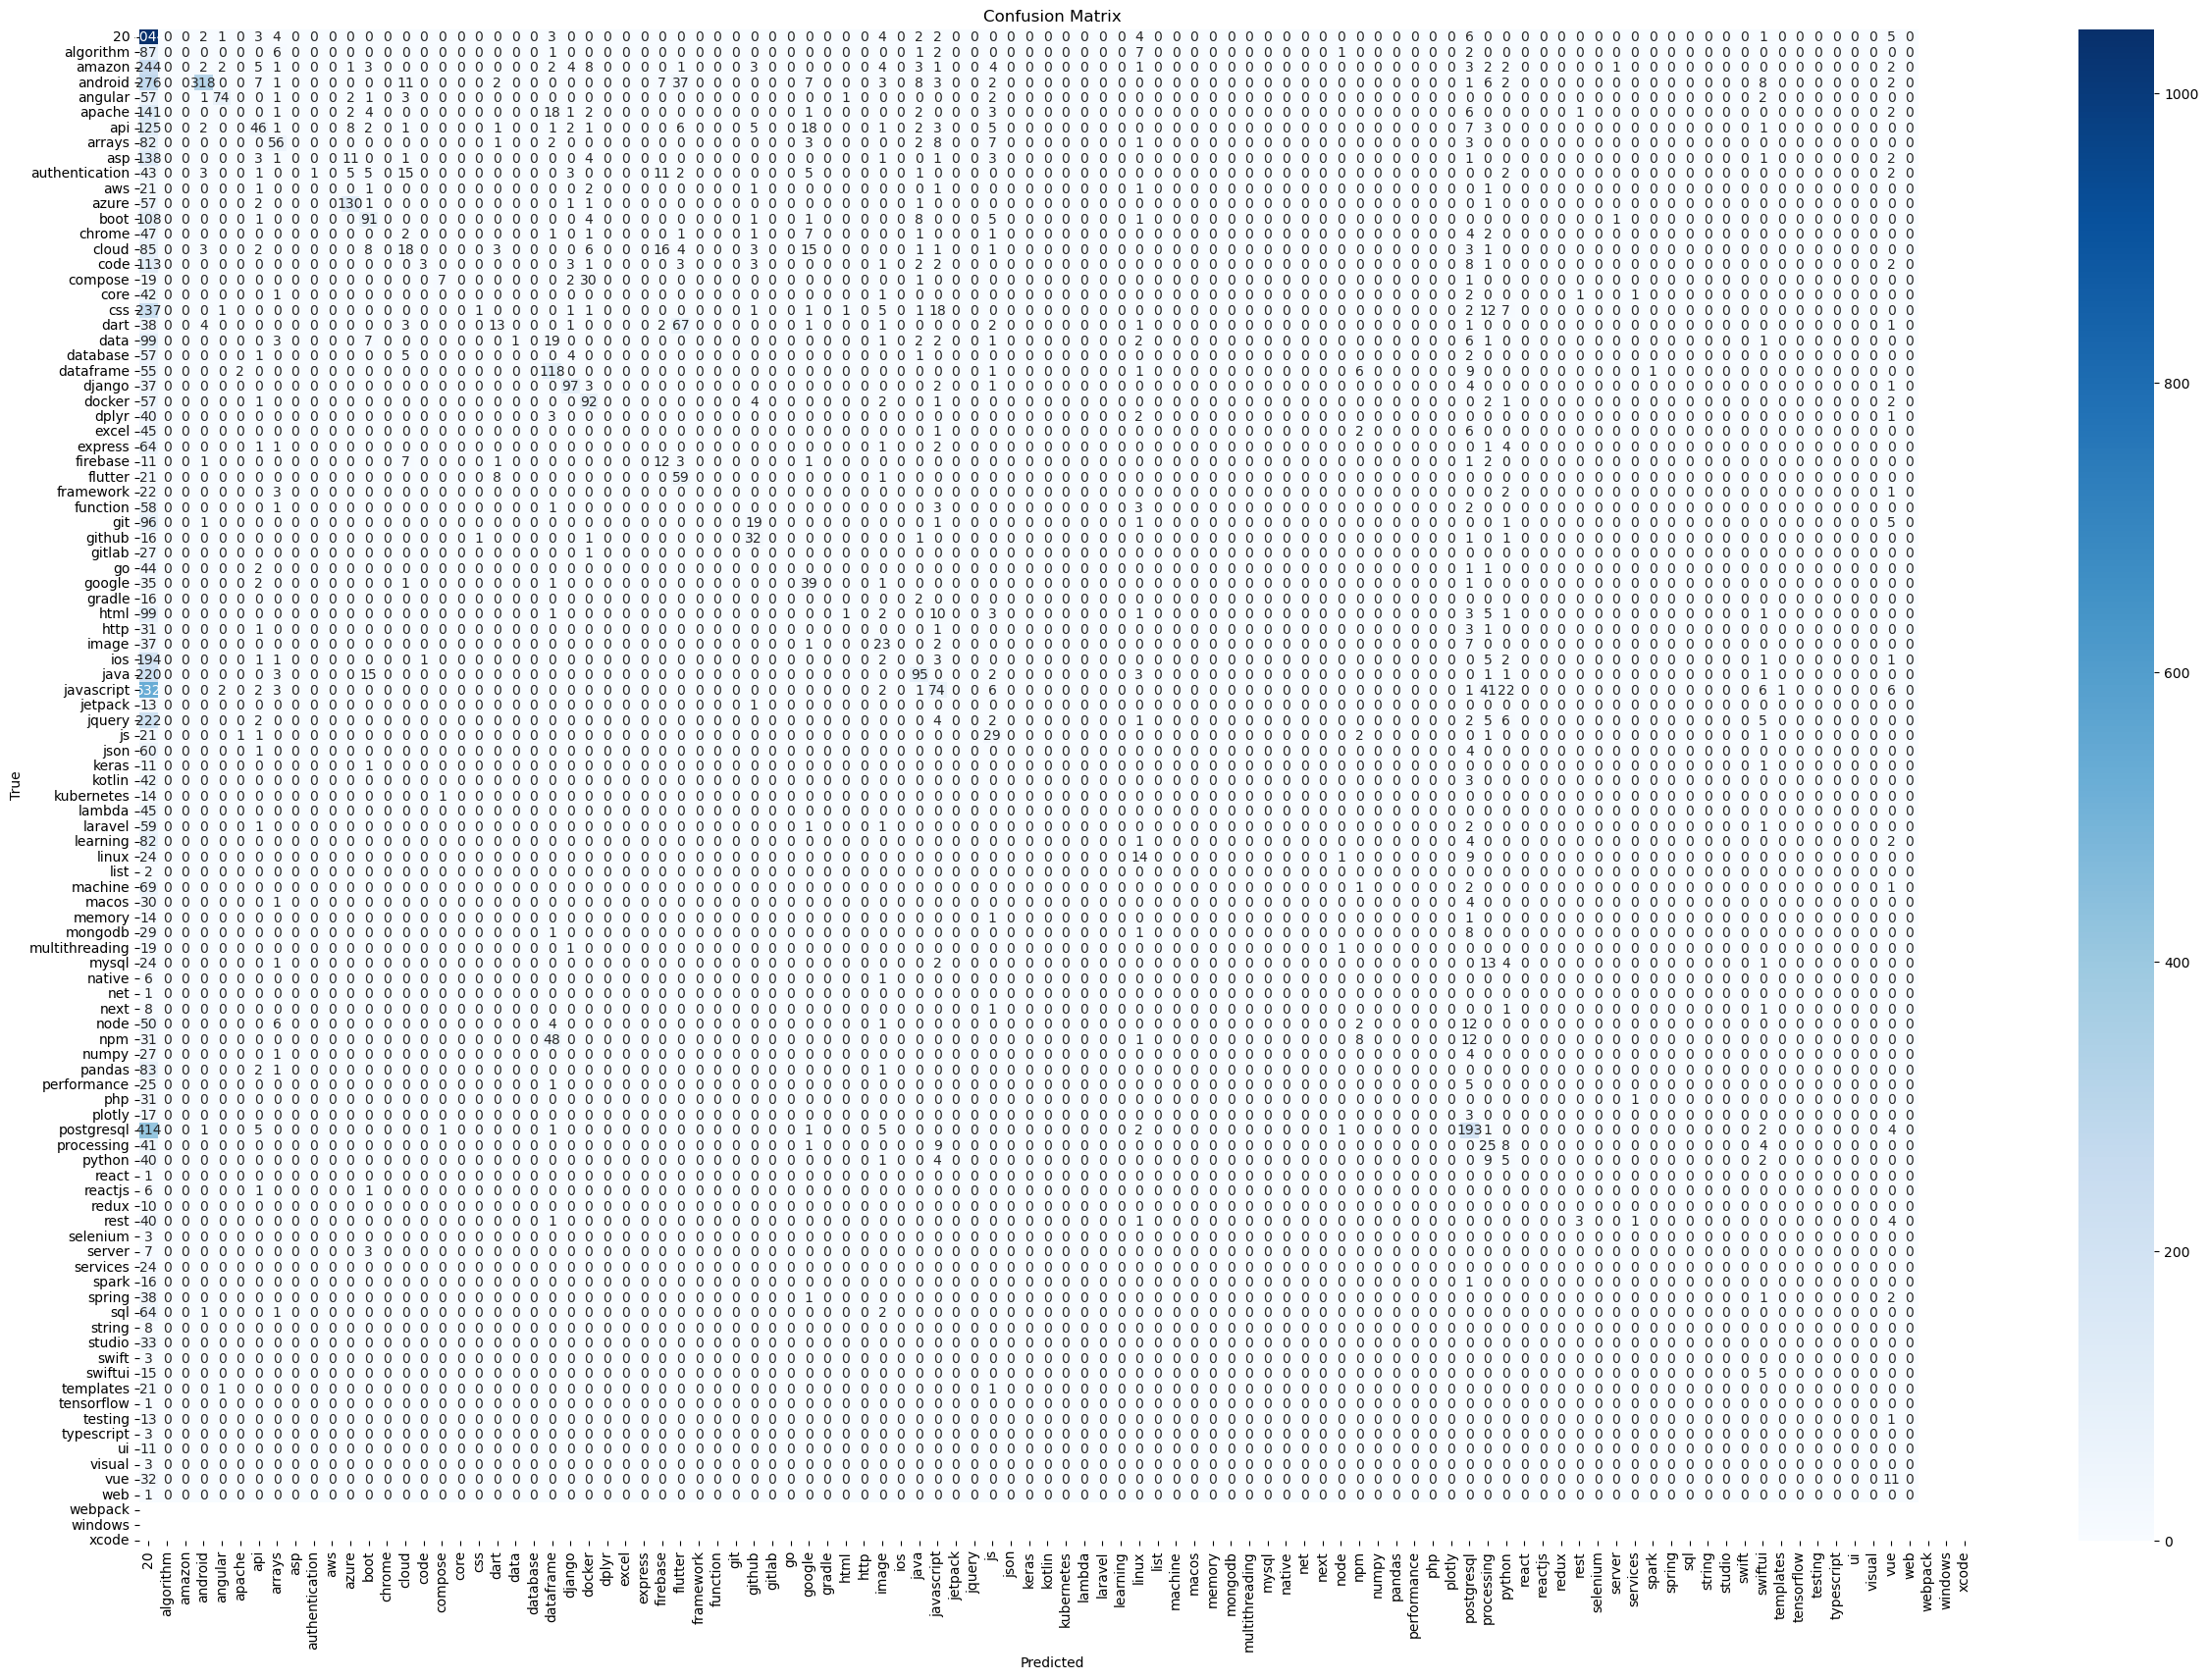

In [10]:
if accuracy_adam>accuracy:
    print(classification_report(y_test, y_pred))
    # Tracer la matrice de confusion
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(30, 20))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# BERT

Chargement des string pour Bert ainsi que passage des tags en liste

In [104]:
data_all = pd.read_csv("data_bag.csv")


In [105]:
import ast

def convert_tags(tag_str):
    """
    Convertit une chaîne de caractères représentant une liste de tags en une liste de tags.

    Args:
        tag_str (str): Chaîne de caractères représentant une liste de tags.

    Returns:
        list: Liste des tags.
    """
    tags_list = ast.literal_eval(tag_str)
    return tags_list

# Appliquer la fonction de conversion à chaque élément de la colonne 'Tags'
data_all['Tags'] = data_all['Tags'].apply(convert_tags)



On va travailler uniquement sur les 100 Tags les plus courrant

In [106]:
# Compter les occurrences de chaque tag
tag_counts = {}
for row in data_all['Tags']:
    for tag in row:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Convertir en DataFrame pour faciliter le tri
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['tag', 'count'])

# Trier par ordre décroissant de fréquence
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

number_tags = 100
# Sélectionner les 100 tags les plus fréquents
top_tags = tag_counts_df.head(number_tags)['tag'].tolist()

# Filtrer les tags dans votre DataFrame d'origine pour ne garder que les 100 tags les plus fréquents
data_all['Tags'] = data_all['Tags'].apply(lambda x: [tag for tag in x if tag in top_tags])

# Afficher les 100 tags les plus fréquents
print("Les",number_tags,"tags les plus fréquents :", top_tags)

# des tags se retouvent vide => on retire les individus
data_all = data_all[data_all['Tags'].apply(len) > 0]


Les 100 tags les plus fréquents : ['python', 'javascript', 'java', 'reactjs', 'android', 'c++', 'node.js', 'r', 'c#', 'flutter', 'html', 'typescript', 'pandas', 'ios', 'docker', 'python-3.x', 'swift', 'css', 'spring-boot', 'kotlin', 'dataframe', 'amazon-web-services', 'php', 'react-native', 'dart', 'firebase', 'vue.js', 'arrays', 'django', 'angular', 'spring', 'c', 'next.js', 'azure', 'git', 'numpy', 'json', 'tensorflow', 'kubernetes', 'linux', 'swiftui', 'macos', 'github', 'windows', 'asp.net-core', 'algorithm', 'postgresql', 'sql', 'visual-studio-code', 'android-studio', 'laravel', 'xcode', 'apache-spark', 'npm', 'android-jetpack-compose', 'jquery', 'performance', 'mongodb', 'webpack', 'multithreading', 'pyspark', 'express', 'keras', 'machine-learning', 'docker-compose', 'list', 'gradle', 'google-cloud-platform', 'excel', 'pytorch', 'selenium', 'c++20', 'react-hooks', 'mysql', 'dplyr', 'wordpress', 'unit-testing', 'go', 'api', 'jestjs', 'powershell', 'string', 'deep-learning', 'openc

Dans le cadre de nos tests, nous avons réduit notre ensemble pour avoir des époch bien plus courtes

In [107]:
# Run this snipet if you want to reduce the size of data_all to reduce the calculation time
data_all = data_all.sample(frac=0.01, random_state=1)

In [108]:
data_all=data_all.drop(['Id'], axis=1)

In [109]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data_all['Tags'])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_all['Title'], y, test_size=0.2, random_state=42)

# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encodage des textes
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Convertir en tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(8)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(8)

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [89]:
len(mlb.classes_)

96

In [110]:
from transformers import BertForSequenceClassification, AdamW

model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.shape[1])
optimizer = AdamW(model_bert.parameters(), lr=2e-5,
              metrics=['accuracy'])

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [102]:
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.shape[1])
# Compiler le modèle

model_bert.compile(optimizer=Adam(learning_rate=2e-5),  # Utilisation de l'identifiant en chaîne de caractères
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
# This code snipet is here to test the behaviour with many epoch
import os

model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.shape[1])
# Compiler le modèle

model_bert.compile(optimizer=Adam(learning_rate=2e-5),  # Utilisation de l'identifiant en chaîne de caractères
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

class MetricsAndModelCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_freq, save_dir):
        super().__init__()
        self.save_freq = save_freq
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            # Save metrics
            with open(os.path.join(self.save_dir, "metrics.log"), 'a') as f:
                f.write(f"Epoch {epoch + 1}: {logs}\n")
            
            # Save model
            model_path = os.path.join(self.save_dir, f"model_epoch_{epoch + 1}")
            self.model.save(model_path)
            print(f"Model saved at {model_path}")

# Set the logging interval and the directory to save metrics and models
save_freq = 5
save_dir = "./saved_models_and_metrics"

# Initialize the custom callback
metrics_and_model_callback = MetricsAndModelCheckpointCallback(save_freq=save_freq, save_dir=save_dir)

# Train the model with the custom callback
history = model_bert.fit(
    train_dataset,
    epochs=2,
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    callbacks=[metrics_and_model_callback]
)

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: compile() got an unexpected keyword argument 'optimizer'

In [15]:
import pickle

# Sauvegarder le modèle
with open('bert_model.pkl', 'wb') as model_file:
    pickle.dump(model_bert, model_file)

# Sauvegarder le tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

INFO:tensorflow:Assets written to: ram://0398de09-90f5-49b5-9bd9-56559133fac2/assets


INFO:tensorflow:Assets written to: ram://0398de09-90f5-49b5-9bd9-56559133fac2/assets


In [17]:
from transformers import BertForSequenceClassification, BertTokenizer

# Sauvegarder le modèle et le tokenizer
model_bert.save_pretrained('./bert/model')
tokenizer.save_pretrained('./bert/tokenizer')

('./bert/tokenizer\\tokenizer_config.json',
 './bert/tokenizer\\special_tokens_map.json',
 './bert/tokenizer\\vocab.txt',
 './bert/tokenizer\\added_tokens.json')

In [57]:
# Prédire sur l'ensemble de test
y_pred_logits = model_bert.predict(test_dataset).logits
y_pred_probs = tf.nn.sigmoid(y_pred_logits)  # Appliquer sigmoid pour obtenir des probabilités
y_pred = tf.where(y_pred_probs >= 0.5, 1, 0) 

'''
# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Tracer la matrice de confusion pour chaque label
for i in range(y_test.shape[1]):
    conf_matrix = confusion_matrix(y_test[:, i], y_pred[:, i])
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {mlb.classes_[i]}')
    plt.show()'''

1158/1158 [==============================] - 60s 49ms/step


'\n# Calculer les métriques\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Accuracy: {accuracy:.2f}")\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred, target_names=mlb.classes_))\n\n# Tracer la matrice de confusion pour chaque label\nfor i in range(y_test.shape[1]):\n    conf_matrix = confusion_matrix(y_test[:, i], y_pred[:, i])\n    plt.figure(figsize=(5, 5))\n    sns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\', cbar=False)\n    plt.xlabel(\'Predicted\')\n    plt.ylabel(\'True\')\n    plt.title(f\'Confusion Matrix for {mlb.classes_[i]}\')\n    plt.show()'

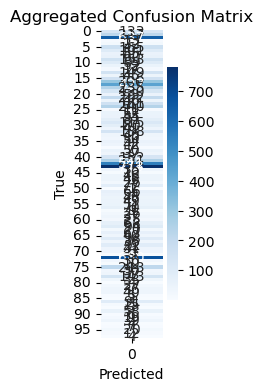

In [58]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculer la matrice de confusion pour l'ensemble de test
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Calculer la matrice de confusion agrégée en sommant sur l'axe des prédictions
aggregated_conf_matrix = conf_matrix.sum(axis=1)
# Convertir aggregated_conf_matrix en un tableau NumPy si ce n'est pas déjà le cas
aggregated_conf_matrix = np.array(aggregated_conf_matrix)

# Assurez-vous que aggregated_conf_matrix est une matrice 2D avec une seule colonne
if aggregated_conf_matrix.ndim == 1:
    aggregated_conf_matrix = aggregated_conf_matrix.reshape(-1, 1)

# Afficher la matrice de confusion agrégée avec Seaborn heatmap
plt.figure(figsize=(1, 4))
sns.heatmap(aggregated_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Aggregated Confusion Matrix')
plt.show()

In [19]:
# Fonction pour afficher les tags prédits pour une entrée spécifique
def predict_tags(title):
    encoding = tokenizer(title, truncation=True, padding=True, max_length=128, return_tensors='tf')
    logits = model_bert(encoding).logits
    probs = tf.nn.sigmoid(logits)
    preds = tf.where(probs >= 0.5, 1, 0)
    predicted_tags = [mlb.classes_[i] for i in range(len(preds[0])) if preds[0][i] == 1]
    return predicted_tags

In [20]:
# Exemple de prédiction pour un nouveau titre
new_title = "synchron python process millisecond level"
predicted_tags = predict_tags(new_title)
print(new_title)
print(predicted_tags)

synchron python process millisecond level
[]


# BERT V2 - WIP

In [51]:
data_all = pd.read_csv("data_bag.csv")
import ast

def convert_tags(tag_str):
    """
    Convertit une chaîne de caractères représentant une liste de tags en une liste de tags.

    Args:
        tag_str (str): Chaîne de caractères représentant une liste de tags.

    Returns:
        list: Liste des tags.
    """
    tags_list = ast.literal_eval(tag_str)
    return tags_list

# Appliquer la fonction de conversion à chaque élément de la colonne 'Tags'
data_all['Tags'] = data_all['Tags'].apply(convert_tags)

In [52]:
# Compter les occurrences de chaque tag
tag_counts = {}
for row in data_all['Tags']:
    for tag in row:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Convertir en DataFrame pour faciliter le tri
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['tag', 'count'])

# Trier par ordre décroissant de fréquence
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

number_tags = 100
# Sélectionner les 100 tags les plus fréquents
top_tags = tag_counts_df.head(number_tags)['tag'].tolist()

# Filtrer les tags dans votre DataFrame d'origine pour ne garder que les 100 tags les plus fréquents
data_all['Tags'] = data_all['Tags'].apply(lambda x: [tag for tag in x if tag in top_tags])

# Afficher les 100 tags les plus fréquents
print("Les",number_tags,"tags les plus fréquents :", top_tags)

# des tags se retouvent vide => on retire les individus
data_all = data_all[data_all['Tags'].apply(len) > 0]

Les 100 tags les plus fréquents : ['python', 'javascript', 'java', 'reactjs', 'android', 'c++', 'node.js', 'r', 'c#', 'flutter', 'html', 'typescript', 'pandas', 'ios', 'docker', 'python-3.x', 'swift', 'css', 'spring-boot', 'kotlin', 'dataframe', 'amazon-web-services', 'php', 'react-native', 'dart', 'firebase', 'vue.js', 'arrays', 'django', 'angular', 'spring', 'c', 'next.js', 'azure', 'git', 'numpy', 'json', 'tensorflow', 'kubernetes', 'linux', 'swiftui', 'macos', 'github', 'windows', 'asp.net-core', 'algorithm', 'postgresql', 'sql', 'visual-studio-code', 'android-studio', 'laravel', 'xcode', 'apache-spark', 'npm', 'android-jetpack-compose', 'jquery', 'performance', 'mongodb', 'webpack', 'multithreading', 'pyspark', 'express', 'keras', 'machine-learning', 'docker-compose', 'list', 'gradle', 'google-cloud-platform', 'excel', 'pytorch', 'selenium', 'c++20', 'react-hooks', 'mysql', 'dplyr', 'wordpress', 'unit-testing', 'go', 'api', 'jestjs', 'powershell', 'string', 'deep-learning', 'openc

In [53]:
data_all = data_all.sample(frac=0.0015, random_state=1)

In [54]:
data_all=data_all.drop(['Id'], axis=1)
train_df, test_df = train_test_split(data_all, test_size=0.2, random_state=42)

# Extraction des textes et des tags
texts = data_all['Title'].tolist()
tags = data_all['Tags'].tolist()

# Création d'un mapping des tags à des indices
unique_tags = set(tag for sublist in tags for tag in sublist)
tag2id = {tag: i for i, tag in enumerate(unique_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

# Conversion des tags en un format binaire
labels = [[1 if tag in tag_list else 0 for tag in unique_tags] for tag_list in tags]

print(len(texts))
print(len(tags))
print(len(labels))
print(len(unique_tags))

69
69
69
56


In [55]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, DataCollatorWithPadding
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [56]:
# Chargement du tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encodage des textes
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=512)

# Création du dataset
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float) 

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = TextDataset(encoded_texts, labels)

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [57]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
# Partitionner le dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Nombre d'exemples dans le dataset d'entraînement : {len(train_dataset)}")
print(f"Nombre d'exemples dans le dataset de test : {len(test_dataset)}")

Nombre d'exemples dans le dataset d'entraînement : 55
Nombre d'exemples dans le dataset de test : 14


In [58]:
# Itération à travers les batches
for batch in test_dataset:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    # Affichage des dimensions des tensors dans le batch
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Attention mask shape: {attention_mask.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Affichage des premiers exemples dans le batch
    print("Premier exemple dans le batch :")
    print(f"Input IDs : {input_ids}")
    print(f"Input IDs type : {input_ids.dtype}")
    print(f"Attention mask : {attention_mask}")
    print(f"Labels : {labels}")
    print(f"Labels type : {labels.dtype}")
    
    break

Input IDs shape: torch.Size([35])
Attention mask shape: torch.Size([35])
Labels shape: torch.Size([56])
Premier exemple dans le batch :
Input IDs : tensor([  101,  8833,  2549,  3501,  2475, 24728, 19666,  2121,  8840, 13344,
         2243,  5754,  4140,  8833,  2549,  3501,  2475,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Input IDs type : torch.int64
Attention mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Labels : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])
Labels type : torch.float32


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [72]:
#Current test
def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions
    # Utiliser un seuil pour convertir les logits en prédictions binaires
    threshold = 0.25
    preds = (logits > threshold).astype(float)


    # Calcul des métriques par exemple pour chaque classe
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='samples', zero_division=0)
    acc = accuracy_score(labels, preds)

    # Afficher quelques exemples pour vérification
    '''    print("Sample Predictions and Labels:")
    for i in range(2):  # Afficher les 5 premiers exemples
        #print(f"logits: {logits[i]}")
        print(f"Predictions: {preds[i]}")
        print(f"Labels: {labels[i]}")
        print(precision)
        #print(recall)
        #print(f1)
        print(acc)'''

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [20]:
def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions
    # Utiliser un seuil pour convertir les logits en prédictions binaires
    threshold = 0
    preds = (logits > threshold).astype(int)
    for i in range(5):  # Afficher les 5 premiers exemples
        print(f"Predictions: {preds[i]}")
        print(f"Labels: {labels[i]}")
    
    # Calcule des métriques par exemple pour chaque classe
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='samples', zero_division=0)
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [74]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

# Définissez votre fonction de perte comme CrossEntropyLoss
loss_fn = torch.nn.BCEWithLogitsLoss()

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(unique_tags),
    id2label=id2tag,
    label2id=tag2id,
    problem_type="multi_label_classification"
)

training_args = TrainingArguments(
    output_dir="./my_model_trans",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
)

# Utiliser un data collator avec padding automatique
data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,  # Ajouter le data collator ici
    compute_metrics=compute_metrics,
)

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None,

In [75]:
trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 10%|█         | 2/20 [00:04<00:39,  2.22s/it]Checkpoint destination directory ./my_model_trans\checkpoint-2 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6864973306655884, 'eval_accuracy': 0.0, 'eval_f1': 0.05229696773814422, 'eval_precision': 0.03321995464852607, 'eval_recall': 0.16666666666666666, 'eval_runtime': 0.2974, 'eval_samples_per_second': 47.082, 'eval_steps_per_second': 3.363, 'epoch': 1.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 20%|██        | 4/20 [00:14<00:57,  3.58s/it]Checkpoint destination directory ./my_model_trans\checkpoint-4 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6630090475082397, 'eval_accuracy': 0.0, 'eval_f1': 0.06349206349206349, 'eval_precision': 0.04186507936507937, 'eval_recall': 0.16666666666666666, 'eval_runtime': 0.3058, 'eval_samples_per_second': 45.784, 'eval_steps_per_second': 3.27, 'epoch': 2.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 30%|███       | 6/20 [00:22<00:50,  3.61s/it]Checkpoint destination directory ./my_model_trans\checkpoint-6 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6417046785354614, 'eval_accuracy': 0.0, 'eval_f1': 0.09041950113378684, 'eval_precision': 0.07091836734693878, 'eval_recall': 0.16666666666666666, 'eval_runtime': 0.3168, 'eval_samples_per_second': 44.192, 'eval_steps_per_second': 3.157, 'epoch': 3.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 40%|████      | 8/20 [00:30<00:42,  3.55s/it]Checkpoint destination directory ./my_model_trans\checkpoint-8 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.626315712928772, 'eval_accuracy': 0.0, 'eval_f1': 0.06462585034013604, 'eval_precision': 0.05952380952380952, 'eval_recall': 0.07738095238095237, 'eval_runtime': 0.3393, 'eval_samples_per_second': 41.261, 'eval_steps_per_second': 2.947, 'epoch': 4.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 50%|█████     | 10/20 [00:37<00:35,  3.55s/it]Checkpoint destination directory ./my_model_trans\checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6103538274765015, 'eval_accuracy': 0.0, 'eval_f1': 0.04081632653061224, 'eval_precision': 0.041666666666666664, 'eval_recall': 0.041666666666666664, 'eval_runtime': 0.3123, 'eval_samples_per_second': 44.824, 'eval_steps_per_second': 3.202, 'epoch': 5.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 60%|██████    | 12/20 [00:44<00:26,  3.37s/it]Checkpoint destination directory ./my_model_trans\checkpoint-12 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5968917608261108, 'eval_accuracy': 0.0, 'eval_f1': 0.06802721088435373, 'eval_precision': 0.06190476190476191, 'eval_recall': 0.1130952380952381, 'eval_runtime': 0.2953, 'eval_samples_per_second': 47.415, 'eval_steps_per_second': 3.387, 'epoch': 6.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 70%|███████   | 14/20 [00:55<00:24,  4.11s/it]

{'eval_loss': 0.5879124402999878, 'eval_accuracy': 0.0, 'eval_f1': 0.023809523809523808, 'eval_precision': 0.014285714285714287, 'eval_recall': 0.07142857142857142, 'eval_runtime': 0.3025, 'eval_samples_per_second': 46.278, 'eval_steps_per_second': 3.306, 'epoch': 7.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 80%|████████  | 16/20 [01:07<00:18,  4.57s/it]

{'eval_loss': 0.5811348557472229, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.3203, 'eval_samples_per_second': 43.71, 'eval_steps_per_second': 3.122, 'epoch': 8.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 90%|█████████ | 18/20 [01:18<00:09,  4.86s/it]Checkpoint destination directory ./my_model_trans\checkpoint-18 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5766324400901794, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.2973, 'eval_samples_per_second': 47.095, 'eval_steps_per_second': 3.364, 'epoch': 9.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
100%|██████████| 20/20 [01:30<00:00,  4.99s/it]

{'eval_loss': 0.574704110622406, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.3013, 'eval_samples_per_second': 46.469, 'eval_steps_per_second': 3.319, 'epoch': 10.0}


100%|██████████| 20/20 [01:44<00:00,  5.22s/it]

{'train_runtime': 104.687, 'train_samples_per_second': 5.254, 'train_steps_per_second': 0.191, 'train_loss': 0.626495361328125, 'epoch': 10.0}


TrainOutput(global_step=20, training_loss=0.626495361328125, metrics={'train_runtime': 104.687, 'train_samples_per_second': 5.254, 'train_steps_per_second': 0.191, 'train_loss': 0.626495361328125, 'epoch': 10.0})

In [76]:
# Évaluer votre modèle sur l'ensemble de test
eval_results = trainer.evaluate(eval_dataset=test_dataset)

C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_17468\679895510.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


In [77]:
def predict_tags(texts, model, tokenizer, threshold=0.5):
    # Tokenizer les textes
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Faire des prédictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Appliquer une fonction sigmoïde aux logits pour obtenir des probabilités
    probs = torch.sigmoid(outputs.logits)

    # Convertir les probabilités en tags (en utilisant un seuil de 0.5 par défaut)
    predicted_tags = (probs > threshold).int()

    # Convertir les indices des tags en noms de tags
    tag_names = []
    for tags in predicted_tags:
        tag_names.append([model.config.id2label[i] for i, tag in enumerate(tags) if tag == 1])

    return tag_names

In [78]:
test_texts = [
    "git bash error code unexpect token.",
    "gener possibl uniqu peptid permut python"
]

# Obtenir les tags pour les textes de test
predicted_tags = predict_tags(test_texts,model,tokenizer,0.6)

# Afficher les résultats
for text, tags in zip(test_texts, predicted_tags):
    print(f"Text: {text}")
    print(f"Predicted tags: {tags}")

Text: git bash error code unexpect token.
Predicted tags: ['docker-compose', 'c++', 'vue.js', 'numpy', 'amazon-web-services', 'typescript']
Text: gener possibl uniqu peptid permut python
Predicted tags: ['c++', 'vue.js', 'html', 'numpy', 'typescript', 'wordpress', 'tensorflow']


# QA

In [21]:
data_all = pd.read_csv("data_bag.csv")
import ast

def convert_tags(tag_str):
    """
    Convertit une chaîne de caractères représentant une liste de tags en une liste de tags.

    Args:
        tag_str (str): Chaîne de caractères représentant une liste de tags.

    Returns:
        list: Liste des tags.
    """
    tags_list = ast.literal_eval(tag_str)
    return tags_list

# Appliquer la fonction de conversion à chaque élément de la colonne 'Tags'
data_all['Tags'] = data_all['Tags'].apply(convert_tags)

# Compter les occurrences de chaque tag
tag_counts = {}
for row in data_all['Tags']:
    for tag in row:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Convertir en DataFrame pour faciliter le tri
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['tag', 'count'])

# Trier par ordre décroissant de fréquence
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

number_tags = 100
# Sélectionner les 100 tags les plus fréquents
top_tags = tag_counts_df.head(number_tags)['tag'].tolist()

# Filtrer les tags dans votre DataFrame d'origine pour ne garder que les 100 tags les plus fréquents
data_all['Tags'] = data_all['Tags'].apply(lambda x: [tag for tag in x if tag in top_tags])

# Afficher les 100 tags les plus fréquents
print("Les",number_tags,"tags les plus fréquents :", top_tags)

# des tags se retouvent vide => on retire les individus
data_all = data_all[data_all['Tags'].apply(len) > 0]

data_all = data_all.sample(frac=0.25, random_state=1)
data_all=data_all.drop(['Id'], axis=1)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data_all['Tags'])
print("Tags après binarisation:", mlb.classes_)

Les 100 tags les plus fréquents : ['python', 'javascript', 'java', 'reactjs', 'android', 'c++', 'node.js', 'r', 'c#', 'flutter', 'html', 'typescript', 'pandas', 'ios', 'docker', 'python-3.x', 'swift', 'css', 'spring-boot', 'kotlin', 'dataframe', 'amazon-web-services', 'php', 'react-native', 'dart', 'firebase', 'vue.js', 'arrays', 'django', 'angular', 'spring', 'c', 'next.js', 'azure', 'git', 'numpy', 'json', 'tensorflow', 'kubernetes', 'linux', 'swiftui', 'macos', 'github', 'windows', 'asp.net-core', 'algorithm', 'postgresql', 'sql', 'visual-studio-code', 'android-studio', 'laravel', 'xcode', 'apache-spark', 'npm', 'android-jetpack-compose', 'jquery', 'performance', 'mongodb', 'webpack', 'multithreading', 'pyspark', 'express', 'keras', 'machine-learning', 'docker-compose', 'list', 'gradle', 'google-cloud-platform', 'excel', 'pytorch', 'selenium', 'c++20', 'react-hooks', 'mysql', 'dplyr', 'wordpress', 'unit-testing', 'go', 'api', 'jestjs', 'powershell', 'string', 'deep-learning', 'openc

In [26]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import TFAutoModelForSequenceClassification


In [27]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
model = TFAutoModelForSequenceClassification.from_pretrained('sentence-transformers/multi-qa-MiniLM-L6-cos-v1', num_labels=len(top_tags))

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceCl

In [28]:
# Tokenizer les textes
X = tokenizer(data_all['Title'].tolist(), padding=True, truncation=True, return_tensors="tf")

In [29]:
# Convertir les étiquettes binarisées en tenseurs
y = tf.convert_to_tensor(y, dtype=tf.float32)

In [30]:
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
with mlflow.start_run(run_name=f"Modèle QA"):
    mlflow.tensorflow.autolog()

    history = model.fit(
        train_dataset,
        epochs=10,
        batch_size=4,
        validation_data=test_dataset,
        validation_steps=len(test_dataset),
    )

2024/06/24 14:17:50 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "tf_bert_for_sequence_classification_1" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/06/24 14:17:52 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets with nested tensors are not supported.
2024/06/24 14:17:52 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets w

Epoch 1/10
   6/4630 [..............................] - ETA: 5:12 - loss: 0.1991 - accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0520s vs `on_train_batch_end` time: 0.0529s). Check your callbacks.


4630/4630 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.0765

2024/06/24 14:23:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/06/24 14:23:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpo9ezrn3j\\latest_checkpoint.h5'


4630/4630 [==============================] - 365s 77ms/step - loss: 0.1288 - accuracy: 0.0765 - val_loss: 0.1005 - val_accuracy: 0.1942
Epoch 2/10
4630/4630 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.1534

2024/06/24 14:29:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/06/24 14:29:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpda_y2ouy\\latest_checkpoint.h5'


4630/4630 [==============================] - 356s 77ms/step - loss: 0.1051 - accuracy: 0.1534 - val_loss: 0.0976 - val_accuracy: 0.1792
Epoch 3/10
4630/4630 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.1945

2024/06/24 14:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/06/24 14:35:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmp_x69d11x\\latest_checkpoint.h5'


4630/4630 [==============================] - 358s 77ms/step - loss: 0.0949 - accuracy: 0.1945 - val_loss: 0.0888 - val_accuracy: 0.2356
Epoch 4/10
4630/4630 [==============================] - 356s 77ms/step - loss: 0.0943 - accuracy: 0.2314 - val_loss: 0.0916 - val_accuracy: 0.2722
Epoch 5/10
4630/4630 [==============================] - 360s 78ms/step - loss: 0.0913 - accuracy: 0.2575 - val_loss: 0.0964 - val_accuracy: 0.1744
Epoch 6/10
4630/4630 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.2406

2024/06/24 14:53:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/06/24 14:53:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpexb2iwbs\\latest_checkpoint.h5'


4630/4630 [==============================] - 367s 79ms/step - loss: 0.0919 - accuracy: 0.2406 - val_loss: 0.0896 - val_accuracy: 0.2636
Epoch 7/10
4630/4630 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.2685

2024/06/24 14:59:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/06/24 14:59:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpbkz7j5ca\\latest_checkpoint.h5'


4630/4630 [==============================] - 362s 78ms/step - loss: 0.0877 - accuracy: 0.2685 - val_loss: 0.0845 - val_accuracy: 0.2925
Epoch 8/10
4630/4630 [==============================] - 356s 77ms/step - loss: 0.0857 - accuracy: 0.2776 - val_loss: 0.0852 - val_accuracy: 0.2825
Epoch 9/10
4630/4630 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.2820

2024/06/24 15:11:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/06/24 15:11:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmp0yqpk80u\\latest_checkpoint.h5'


4630/4630 [==============================] - 353s 76ms/step - loss: 0.0853 - accuracy: 0.2820 - val_loss: 0.0835 - val_accuracy: 0.2611
Epoch 10/10
1/1 [==============================] - 1s 1s/step


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmp7pt2841b\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmp7pt2841b\model\data\model\assets
2024/06/24 15:18:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\BEAST-~1\AppData\Local\Temp\tmp7pt2841b\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.1']. Set logging level to DEBUG to see the full traceback. 


In [28]:
#history = model.fit(X.data, y, epochs=9, batch_size=4)

Epoch 1/9
2894/2894 [==============================] - 247s 82ms/step - loss: 0.1697 - accuracy: 0.0627
Epoch 2/9
2894/2894 [==============================] - 247s 85ms/step - loss: 0.1399 - accuracy: 0.1357
Epoch 3/9
2894/2894 [==============================] - 243s 84ms/step - loss: 0.1275 - accuracy: 0.1626
Epoch 4/9
2894/2894 [==============================] - 2027s 701ms/step - loss: 0.1222 - accuracy: 0.1859
Epoch 5/9
2894/2894 [==============================] - 238s 82ms/step - loss: 0.1133 - accuracy: 0.2045
Epoch 6/9
2894/2894 [==============================] - 227s 78ms/step - loss: 0.1146 - accuracy: 0.1776
Epoch 7/9
2894/2894 [==============================] - 214s 74ms/step - loss: 0.1220 - accuracy: 0.1215
Epoch 8/9
2894/2894 [==============================] - 214s 74ms/step - loss: 0.1116 - accuracy: 0.1641
Epoch 9/9
2894/2894 [==============================] - 214s 74ms/step - loss: 0.1079 - accuracy: 0.2126


In [31]:
# Nouveau texte à classifier
new_texts = ["youtub ifram work googl interact canva load googl", "discord python ad user input command use choic oppos wait_for"]

# Tokenizer les nouveaux textes
new_X = tokenizer(new_texts, padding=True, truncation=True, return_tensors="tf")

# Faire des prédictions
predictions = model.predict(new_X.data)

# Convertir les prédictions en tags
predicted_tags = mlb.inverse_transform(predictions.logits > 0.1)

# Afficher les prédictions avec les scores
for i, text in enumerate(new_texts):
    print(f"Texte: {text}")
    print(f"Tags prédits: {predicted_tags[i]}")
    print(f"Scores de prédiction:")
    for tag, score in zip(mlb.classes_, predictions.logits[i]):
        if score >0:
            print(f"{tag}: {score:.4f}")
    print()

1/1 [==============================] - 0s 88ms/step
Texte: youtub ifram work googl interact canva load googl
Tags prédits: ('html', 'javascript', 'node.js', 'reactjs', 'typescript')
Scores de prédiction:
algorithm: 0.0001
arrays: 0.0609
css: 0.0900
html: 0.1108
javascript: 0.4222
jquery: 0.0986
node.js: 0.1178
npm: 0.0545
r: 0.0574
react-native: 0.0494
reactjs: 0.3149
typescript: 0.1252
vue.js: 0.0760
xcode: 0.0469

Texte: discord python ad user input command use choic oppos wait_for
Tags prédits: ('django', 'pandas', 'python', 'python-3.x')
Scores de prédiction:
algorithm: 0.0578
arrays: 0.0332
c: 0.0219
c++: 0.0147
dataframe: 0.0904
django: 0.1479
function: 0.0776
html: 0.0305
javascript: 0.0521
jquery: 0.0085
keras: 0.0645
list: 0.0445
machine-learning: 0.0410
node.js: 0.0092
pandas: 0.1221
performance: 0.0492
powershell: 0.0091
python: 0.5893
python-3.x: 0.1175
r: 0.0454
tensorflow: 0.0434
visual-studio-code: 0.0978



In [32]:
X = tokenizer(data_all['Title'].tolist(), padding=True, truncation=True, return_tensors="tf")

# Faire des prédictions
predictions = model.predict(X.data)

# Enregistrer les prédictions dans data_all["QA_predict"]
data_all["QA_predict"] = predictions.logits.argmax(axis=1)

362/362 [==============================] - 12s 34ms/step
